In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

## Upload raw dataset

### Below is script used to restructure and split the raw dataset, which happens on the local machine


In [ ]:
import os
import shutil
import random

DATASET_PATH = 'Columbia_Gaze_Data_Set'

def data_processing(dataset_path):
    gazing_images = []
    no_gazing_images = []

    for image_directory in os.listdir(dataset_path):
        full_dir_path = os.path.join(dataset_path, image_directory)

        # check if the path is a directory
        if os.path.isdir(full_dir_path):
            for image_file in os.listdir(full_dir_path):
                # make sure we are working with .jpg file
                if image_file.endswith('.jpg'):
                    full_img_path = os.path.join(full_dir_path, image_file)

                    if '_0V_0H' in image_file or '_0V_5H' in image_file or '_0V_-5H' in image_file:
                        gazing_images.append(full_img_path)
                    else:
                        no_gazing_images.append(full_img_path)

    # shuffle the list
    random.shuffle(gazing_images)
    random.shuffle(no_gazing_images)
    print(len(gazing_images))
    print(len(no_gazing_images))

    # split the images into training and test sets by 90%
    gazing_train = gazing_images[:int(len(gazing_images) * 0.9)]
    gazing_test = gazing_images[int(len(gazing_images) * 0.9):]

    # to avoid oversampling the majority class, we decrease by the ratio of no-gazing samples
    no_gazing_images = no_gazing_images[:int(0.16 * len(no_gazing_images))]
    no_gazing_train = no_gazing_images[:int(len(no_gazing_images) * 0.9)]
    no_gazing_test = no_gazing_images[int(len(no_gazing_images) * 0.9):]

    # make output directories
    os.makedirs('train4/gazing', exist_ok=True)
    os.makedirs('train4/no_gazing', exist_ok=True)
    os.makedirs('test4/gazing', exist_ok=True)
    os.makedirs('test4/no_gazing', exist_ok=True)

    # copy the images
    for img in gazing_train:
        shutil.copy(img, 'train4/gazing')

    for img in gazing_test:
        shutil.copy(img, 'test4/gazing')

    for img in no_gazing_train:
        shutil.copy(img, 'train4/no_gazing')

    for img in no_gazing_test:
        shutil.copy(img, 'test4/no_gazing')

# call the function
# data_processing(DATASET_PATH)

In [ ]:
!pip install PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
download = drive.CreateFile({'id': '1zEhw81o0JcjVqUVX0Cj2fasV8yHVQjDH'})
download.GetContentFile('train.zip')

In [ ]:
download = drive.CreateFile({'id': '1GfTqqDSHpA83CUOLHhcDYqprZ2WXQnsW'})
download.GetContentFile('test.zip')

In [ ]:
import zipfile

# Extract the archive
local_zip = 'train2.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('train2')
zip_ref.close()

local_zip = 'test2.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('test2')
zip_ref.close()

### Inspect the data

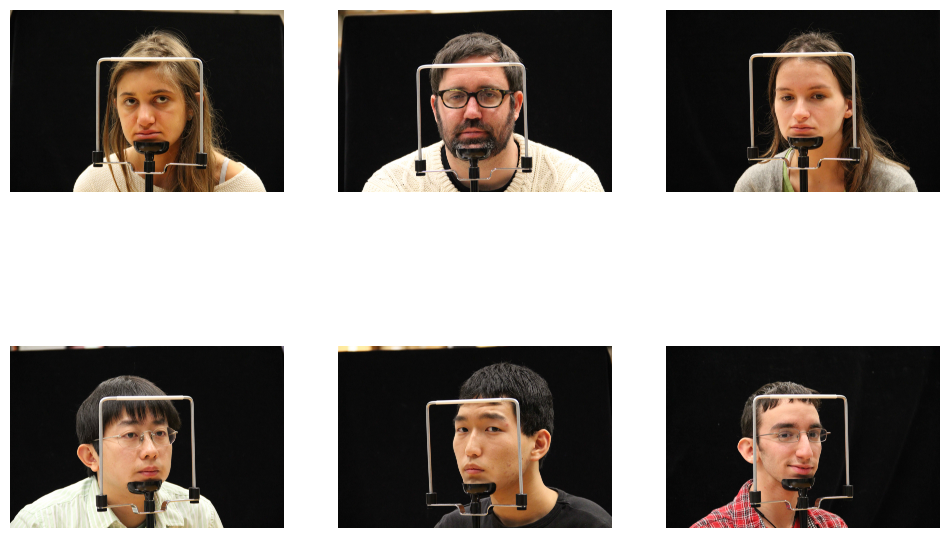

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

base_dir = 'train2/train2'

gazing_dir = os.path.join(base_dir, 'gazing')
no_gazing_dir = os.path.join(base_dir, 'no_gazing')

sample_index = 3

next_gazing = [os.path.join(gazing_dir, fname) for fname in os.listdir(gazing_dir)[sample_index-3:sample_index]]
next_no_gazing = [os.path.join(no_gazing_dir, fname) for fname in os.listdir(no_gazing_dir)[sample_index-3:sample_index]]

images = next_gazing + next_no_gazing  # combine the image lists

nrows = len(images) // 3
if len(images) % 3:
    nrows += 1

plt.figure(figsize=(12, nrows * 4))
for i, img_path in enumerate(images):
    img = mpimg.imread(img_path)
    plt.subplot(nrows, 3, i + 1)
    plt.imshow(img)
    plt.axis('Off')
plt.show()



## Define the model and preprocess images using tensorflow

### Transfer learning, Inception network

In [ ]:
# download the weights for Inception network

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-07-26 20:54:54--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 74.125.128.128, 74.125.143.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/inception_v3_weigh 100%[===================>]  83.84M  25.6MB/s    in 3.3s    

2023-07-26 20:54:58 (25.6 MB/s) - ‘/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (300, 300, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

In [ ]:
# as the input file size is big, we add one more Cov2D layer at the top
last_layer = pre_trained_model.get_layer('mixed10')
last_layer.output_shape
last_output = last_layer.output

In [ ]:
from tensorflow.keras import Model

# x = layers.Conv2D(512, (3,3), activation='relu')(last_output)
# x = layers.MaxPooling2D(2, 2)(x)
x = layers.MaxPooling2D()(last_output)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation='sigmoid')(x)

# append above layers to pretrained model
model = Model(pre_trained_model.input, x)

model.summary()


In [ ]:
# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def train_val_generators(TRAIN_DIR, VAL_DIR):
  train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip=True,
                                      fill_mode='nearest')

  validation_datagen = ImageDataGenerator(rescale = 1./255)

  train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                      target_size=(300, 300),
                                                      batch_size = 16,
                                                      class_mode='binary',
                                                      )

  validation_generator = validation_datagen.flow_from_directory(VAL_DIR,
                                                      target_size=(300, 300),
                                                      batch_size = 16,
                                                      class_mode='binary',
                                                      )

  return train_generator, validation_generator

In [ ]:
TRAIN_DIR = "train2/train2"
TEST_DIR = "test2/test2"

train_generator, validation_generator = train_val_generators(TRAIN_DIR, TEST_DIR)

Found 1663 images belonging to 2 classes.
Found 185 images belonging to 2 classes.


In [ ]:
# train the model

history = model.fit(train_generator,
          validation_data = validation_generator,
          epochs = 10)

Epoch 1/10
104/104 [==============================] - 202s 2s/step - loss: 8.5948 - accuracy: 0.5039 - val_loss: 0.6808 - val_accuracy: 0.5297
Epoch 2/10
104/104 [==============================] - 169s 2s/step - loss: 0.7802 - accuracy: 0.5207 - val_loss: 0.6907 - val_accuracy: 0.5568
Epoch 3/10
104/104 [==============================] - 183s 2s/step - loss: 0.7187 - accuracy: 0.5418 - val_loss: 0.6893 - val_accuracy: 0.5459
Epoch 4/10
104/104 [==============================] - 173s 2s/step - loss: 0.7365 - accuracy: 0.5388 - val_loss: 0.6895 - val_accuracy: 0.5459
Epoch 5/10
104/104 [==============================] - 168s 2s/step - loss: 0.7056 - accuracy: 0.5478 - val_loss: 0.6892 - val_accuracy: 0.5459
Epoch 6/10
104/104 [==============================] - 189s 2s/step - loss: 0.6917 - accuracy: 0.5448 - val_loss: 0.6889 - val_accuracy: 0.5459
Epoch 7/10
104/104 [==============================] - 177s 2s/step - loss: 0.6920 - accuracy: 0.5472 - val_loss: 0.6889 - val_accuracy: 0.5459

In [ ]:
model.save('initial_model2.h5')

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

#### Load model and Prediction

In [ ]:
initial_model = load_model('initial_model.h5')

OSError: ignored

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-rw-r--r-- 1 root root 278M Jul 23 05:48 initial_model.h5


## New Model Using a Face Detecor to Crop Training Data

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
! pip install mediapipe

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
import cv2
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.models import Model

#### 1. Load preprocessed data and generate new train and test data in memory

In [ ]:
import zipfile

# Extract the archive
local_zip = 'train4.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('train4')
zip_ref.close()

local_zip = 'test4.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('test4')
zip_ref.close()

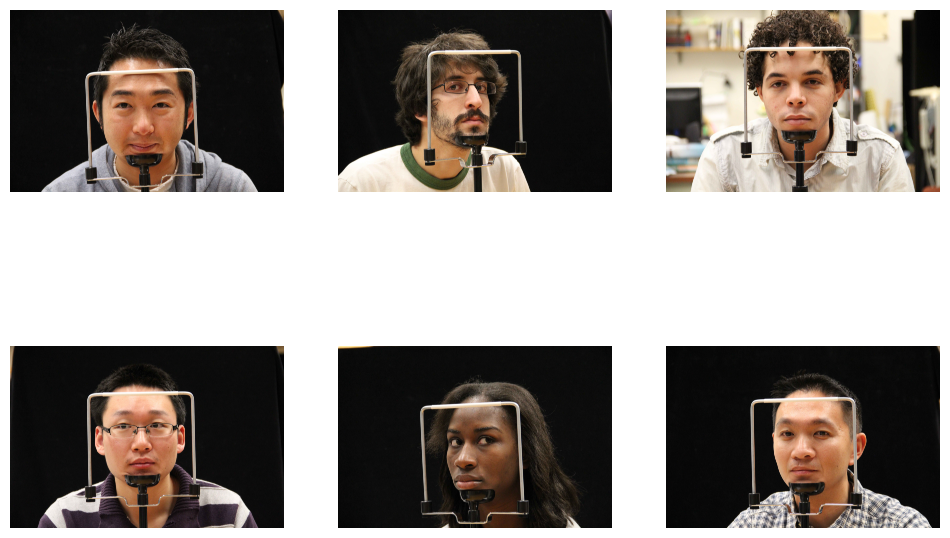

In [ ]:
# Train and test data sample

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

base_dir = 'train4/train4'

gazing_dir = os.path.join(base_dir, 'gazing')
no_gazing_dir = os.path.join(base_dir, 'no_gazing')

sample_size = 3

next_gazing = [os.path.join(gazing_dir, fname) for fname in os.listdir(gazing_dir)[10:10 + sample_size]]
next_no_gazing = [os.path.join(no_gazing_dir, fname) for fname in os.listdir(no_gazing_dir)[10:10+ sample_size]]

images = next_gazing + next_no_gazing  # combine the image lists

nrows = len(images) // 3
if len(images) % 3:
    nrows += 1

plt.figure(figsize=(12, nrows * 4))
for i, img_path in enumerate(images):
    img = mpimg.imread(img_path)
    plt.subplot(nrows, 3, i + 1)
    plt.imshow(img)
    plt.axis('Off')
plt.show()


In [ ]:
def image_loader(img_path):
  raw_image = load_img(img_path)
  image = img_to_array(raw_image).astype('uint8')
  return image

def show_image(image_array):
  plt.imshow(image_array)
  plt.axis('Off')
  plt.show()
  print(image_array.shape)


train4/train4/gazing/0011_2m_-30P_0V_-5H.jpg
(2117, 2856)
(3632, 1341)


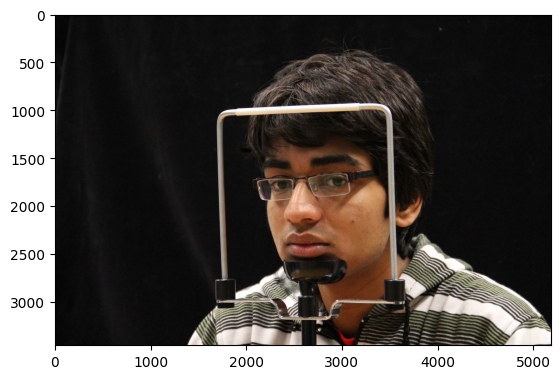

In [ ]:
# Use a face detector to predict both train and test datasets

# make a face detection solution instance
mp_face_detection = mp.solutions.face_detection

sample_index = 9

# sample an image
image_path = os.path.join(gazing_dir, os.listdir(gazing_dir)[sample_index])
print(image_path)
raw_image = load_img(image_path)
image = img_to_array(raw_image).astype('uint8')  # face_detector expects data type tp be uin8


with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detector:
  # get the shape of the image
  image_height, image_width, _ = image.shape

  result = face_detector.process(image)
  if result.detections:
      for detection in result.detections:
          bbx = detection.location_data.relative_bounding_box

          face_coordinates = np.multiply([bbx.xmin, bbx.ymin, bbx.width, bbx.height],
                                          [image_width, image_height, image_width, image_height]).astype(int)

          start_y = face_coordinates[1]
          start_x = face_coordinates[0]
          width = face_coordinates[2]
          height = face_coordinates[3]

          start_point = (start_x, start_y + height)
          end_point = (start_x + width, start_y)
          print(start_point)
          print(end_point)

          # cv2.rectangle(image, start_point, end_point, (255,0,0), 3)
          # cv2.imshow("Detection Results", image)
          plt.imshow(image)
          plt.show()


#### DEFINE FUNCTIONS TO CROP IMAGES AND SAVE THEM INTO ARRAYS

In [ ]:
def get_cropped_image_face_uint8(image, face_detector):
  # crop the image
  image_height, image_width, _ = image.shape

  result = face_detector.process(image)
  if result.detections:
    for detection in result.detections:
      bbx = detection.location_data.relative_bounding_box

      # mediapipe returns the relative coordinates of the bounding box
      # multiply by the height and width in pixles
      face_coordinates = np.multiply([bbx.xmin, bbx.ymin, bbx.width, bbx.height],
                                    [image_width, image_height, image_width, image_height]).astype(int)

      start_y = face_coordinates[1]
      start_x = face_coordinates[0]
      width = face_coordinates[2]
      height = face_coordinates[3]

      # crop the image
      cropped_image = tf.image.crop_to_bounding_box(image, start_y, start_x, height, width)

      # resize it to be (299, 299) for model training purpose
      cropped_image = tf.image.resize(cropped_image, (299,299))

      # convert tensor into numpy arrays
      cropped_image = cropped_image.numpy().astype('uint8') # otherwise we cannot plot it
  return cropped_image



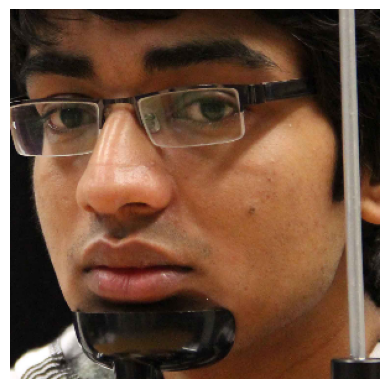

(299, 299, 3)


In [ ]:
# Crop the sample image

# image = image_loader('train3/train3/gazing/0035_2m_-15P_0V_0H.jpg')

with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detector:
  cropped_image = get_cropped_image_face_uint8(image, face_detector)
  show_image(cropped_image)

In [ ]:
# process each image and use tf.image.crop_to_bounding_box to get the face areas
def read_and_crop_images_dir(dir, face_detector):
  image_list = []
  file_path_list = [os.path.join(dir, file) for file in os.listdir(dir)]
  filenames_list = [] # to store the filenames
  # read the image
  for file_path in file_path_list:
    try:
      if file_path.endswith(('jpg', 'jpeg')):
        # raw_image = load_img(file_path)
        # image = img_to_array(raw_image).astype('uint8') # face detector expects data type to be uint8
        image = image_loader(file_path)

        # get cropped image
        cropped_image = get_cropped_image_face_uint8(image, face_detector)

        # add the cropped image array to the list
        image_list.append(cropped_image)

        # add the filename to the list
        filenames_list.append(os.path.basename(file_path))
      else:
            print(f"No detections found in file {file_path}")

    except Exception as e:
            print(f"Error processing file {file_path}: {e}")
  return image_list, filenames_list

In [ ]:
# Prepare training and testing data
train_base_dir = 'train4/train4'
test_base_dir = 'test4/test4'

train_gazing_dir = os.path.join(train_base_dir, 'gazing')
train_no_gazing_dir = os.path.join(train_base_dir, "no_gazing")
test_gazing_dir = os.path.join(test_base_dir, 'gazing')
test_no_gazing_dir = os.path.join(test_base_dir, "no_gazing")

# read all data into a data structure, but without labels
with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detector:
  train_gazing, train_gazing_filenames = read_and_crop_images_dir(train_gazing_dir, face_detector)
  train_no_gazing, train_no_gazing_filenames = read_and_crop_images_dir(train_no_gazing_dir, face_detector)
  test_gazing, test_gazing_filenames = read_and_crop_images_dir(test_gazing_dir, face_detector)
  test_no_gazing, test_no_gazing_filenames = read_and_crop_images_dir(test_no_gazing_dir, face_detector)

# in order to use the flow() method of keras.preprocessing.image API, we need to prepare x_train and y_train

# concatenate data and convert them into numpy arrays
x_train = np.concatenate([train_gazing, train_no_gazing])
x_test = np.concatenate([test_gazing, test_no_gazing])

train_filenames = train_gazing_filenames + train_no_gazing_filenames
test_filenames = test_gazing_filenames + test_no_gazing_filenames

# crate labels, '1' for gazing and '0' for no_gazing
y_train = np.concatenate([np.ones(len(train_gazing)), np.zeros(len(train_no_gazing))])
y_test = np.concatenate([np.ones(len(test_gazing)), np.zeros(len(test_no_gazing))])

# shuffle both x, y and filenames but maintain their correspondence
x_train, y_train, train_filenames = shuffle(x_train, y_train, train_filenames, random_state=0)
x_test, y_test, test_filenames = shuffle(x_test, y_test, test_filenames, random_state=0)


Error processing file train3/train3/gazing/0035_2m_-15P_0V_0H.jpg: offset_height must be >= 0.


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(503, 299, 299, 3)
(503,)
(56, 299, 299, 3)
(56,)


In [ ]:
y_train

In [ ]:
idx = 0

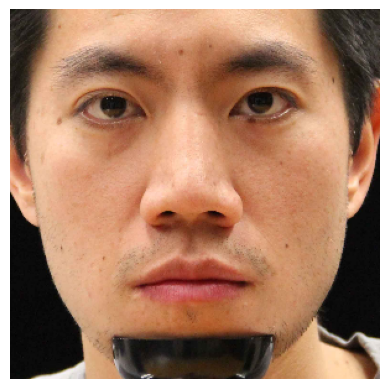

(299, 299, 3)
1.0
0014_2m_0P_0V_0H.jpg


In [ ]:
show_image(x_train[idx])
print(y_train[idx])
print(train_filenames[idx])

idx += 1

In [ ]:
show_image(image)

#### DEFINE FUNCTIONS TO CROP IMAGES BUT SAVE THEM INTO LOCAL DIRECTORIES

In [ ]:
# NEW

def get_cropped_image_face(image, face_detector):
    # crop the image
    image_height, image_width, _ = image.shape

    result = face_detector.process(image)
    if result.detections:
        for detection in result.detections:
            bbx = detection.location_data.relative_bounding_box

            # mediapipe returns the relative coordinates of the bounding box
            # multiply by the height and width in pixels
            face_coordinates = np.multiply([bbx.xmin, bbx.ymin, bbx.width, bbx.height],
                                        [image_width, image_height, image_width, image_height]).astype(int)

            start_y = face_coordinates[1]
            start_x = face_coordinates[0]
            width = face_coordinates[2]
            height = face_coordinates[3]

            # crop the image
            cropped_image = tf.image.crop_to_bounding_box(image, start_y, start_x, height, width)

            # resize it to be (299, 299) for model training purpose
            cropped_image = tf.image.resize(cropped_image, (299,299))

    return cropped_image




In [ ]:
mp_face_mesh = mp.solutions.face_mesh

In [ ]:
def get_cropped_image_eye(image, mp_face_mesh):

    height, width, _ = image.shape

    face_mesh = mp_face_mesh.FaceMesh()
    results = face_mesh.process(image)

    if results.multi_face_landmarks:
      for face_landmarks in results.multi_face_landmarks:
        p1, p2 = face_landmarks.landmark[70], face_landmarks.landmark[340]
        x1 = int(p1.x * width)
        y1 = int(p1.y * height)
        x2 = int(p2.x * width)
        y2 = int(p2.y * height)

        # Ensure y1 is smaller and y2 is larger
        if y1 > y2:
            y1, y2 = y2, y1

        top_left = (x1, y1)
        lower_right = (x2, y2)

      # crop the image
      cropped_image = tf.image.crop_to_bounding_box(image, y1, x1, y2-y1, x2-x1)

      # resize it to be (100, 400) for model training purpose
      cropped_image = tf.image.resize(cropped_image, (100,400)).numpy().astype('uint8')

      return cropped_image



In [ ]:
cropped_image = get_cropped_image_eye(image, mp_face_mesh)
show_image(cropped_image)

NameError: ignored

In [ ]:
# NEW

def crop_images_and_save(dir, detector):
    # image_list = []
    file_path_list = [os.path.join(dir, file) for file in os.listdir(dir)]
    # filenames_list = [] # to store the filenames

    # Define your new directories
    new_dirs = ["trainh/gazing", "trainh/no_gazing", "testh/gazing", "testh/no_gazing"]

    for new_dir in new_dirs:
        if not os.path.exists(new_dir):
            os.makedirs(new_dir)

    # read the image
    for file_path in file_path_list:
        try:
            if file_path.endswith(('jpg', 'jpeg')):
                # raw_image = load_img(file_path)
                # image = img_to_array(raw_image).astype('uint8') # face detector expects data type to be uint8
                image = image_loader(file_path)

                # Define which directory you want to save the image to
                if "no_gazing" in file_path:
                    if "train" in file_path:
                        save_dir = "trainh/no_gazing"
                    else:
                        save_dir = "testh/no_gazing"
                else:
                    if "train" in file_path:
                        save_dir = "trainh/gazing"
                    else:
                        save_dir = "testh/gazing"

                # get cropped image
                cropped_image = get_cropped_image_eye(image, mp_face_mesh)

                # # add the cropped image array to the list
                # image_list.append(cropped_image)

                # # add the filename to the list
                # filenames_list.append(os.path.basename(file_path))

                # Save the image to the specified directory
                save_img(os.path.join(save_dir, os.path.basename(file_path)), cropped_image)

                # Explicitly delete variables to limit RAM usage
                del image
                del cropped_image

                # Run the garbage collector
                gc.collect()

            else:
                print(f"No detections found in file {file_path}")

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    # Explicitly delete large data structures at the end
    del file_path_list
    gc.collect()

    return



In [ ]:
# Prepare training and testing data
train_base_dir = 'train4/train4'
test_base_dir = 'test4/test4'

train_gazing_dir = os.path.join(train_base_dir, 'gazing')
train_no_gazing_dir = os.path.join(train_base_dir, "no_gazing")
test_gazing_dir = os.path.join(test_base_dir, 'gazing')
test_no_gazing_dir = os.path.join(test_base_dir, "no_gazing")

# read all data into a data structure, but without labels
# with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detector:



In [ ]:
# to save RAM usage
crop_images_and_save(train_gazing_dir, mp_face_mesh)

In [ ]:
crop_images_and_save(train_no_gazing_dir, mp_face_mesh)

In [ ]:
crop_images_and_save(test_gazing_dir, mp_face_mesh)

In [ ]:
crop_images_and_save(test_no_gazing_dir, mp_face_mesh)

#### 3. Define model using transfer learning and train the model

In [ ]:
# tuning the learning rate
# assume 10 epochs training

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 100))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import layers

# Load the InceptionV3 model, excluding the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Choose `mixed_7` as the last layer of your base model
last_layer = base_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense (1, activation='sigmoid')(x)

# add a GlobalAveragePooling and Dense layer
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(1, activation='sigmoid')(x)

face_cropped_model = Model(inputs=base_model.input, outputs=x)

# freeze all layers in IncepionV3 model
# for layer in base_model.layers:
#   layer.trainable = False

# Here we are unfreezing the top 20 layers
# for layer in base_model.layers[:-20]:
#     layer.trainable = False

# for layer in base_model.layers[-20:]:
#     layer.trainable = True


# compile the model
face_cropped_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


last layer output shape:  (None, 17, 17, 768)


In [ ]:
face_cropped_model.summary()

In [ ]:
# create augmentaion using imageDataGenerator

def train_val_generators_flow(x_train, y_train, x_test, y_test):
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  validation_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow(x_train,
                                       y_train,
                                       batch_size = 8
                                      )

  # no augmentatiin for validation set
  validation_generator = validation_datagen.flow(x_test,
                                                 y_test,
                                                 batch_size = 8
                                                )

  return train_generator, validation_generator


def train_val_generators_flow_from_directory(TRAIN_DIR, VAL_DIR):
  train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip=True,
                                      fill_mode='nearest')

  validation_datagen = ImageDataGenerator(rescale = 1./255)

  train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                      target_size=(100, 400),
                                                      batch_size = 8,
                                                      class_mode='binary',
                                                      )

  validation_generator = validation_datagen.flow_from_directory(VAL_DIR,
                                                      target_size=(100, 400),
                                                      batch_size = 8,
                                                      class_mode='binary',
                                                      )

  return train_generator, validation_generator




In [ ]:
train_generator, validation_generator = train_val_generators_flow_from_directory('trainh', 'testh')

Found 1280 images belonging to 2 classes.
Found 330 images belonging to 2 classes.


In [ ]:
# define a custom model

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 400, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2, 2),
    # tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-2),
              metrics=['accuracy'])


In [ ]:
# define a vgg16 pretrained model

input_layer = Input(shape=(100,400,3))
vgg = VGG16(include_top = False)(input_layer)

# classification model
f1 = GlobalMaxPooling2D()(vgg)
class1 = Dense(2048, activation='relu')(f1)
class2 = Dense(1, activation='sigmoid')(class1)

vgg_model = Model(inputs=input_layer, outputs=class2)

vgg_model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-6),
              metrics=['accuracy'])

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
hist = vgg_model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch = 1280/8,
                              epochs=500)

Epoch 1/500
160/160 [==============================] - 39s 131ms/step - loss: 0.6992 - accuracy: 0.5156 - val_loss: 0.6951 - val_accuracy: 0.5061
Epoch 2/500
160/160 [==============================] - 21s 129ms/step - loss: 0.6954 - accuracy: 0.5250 - val_loss: 0.6940 - val_accuracy: 0.4939
Epoch 3/500
160/160 [==============================] - 21s 132ms/step - loss: 0.6909 - accuracy: 0.5211 - val_loss: 0.6927 - val_accuracy: 0.5061
Epoch 4/500
160/160 [==============================] - 22s 134ms/step - loss: 0.6948 - accuracy: 0.5063 - val_loss: 0.6923 - val_accuracy: 0.5273
Epoch 5/500
160/160 [==============================] - 21s 133ms/step - loss: 0.6899 - accuracy: 0.5367 - val_loss: 0.6951 - val_accuracy: 0.4970
Epoch 6/500
160/160 [==============================] - 21s 133ms/step - loss: 0.6922 - accuracy: 0.5305 - val_loss: 0.6900 - val_accuracy: 0.5394
Epoch 7/500
160/160 [==============================] - 21s 132ms/step - loss: 0.6925 - accuracy: 0.5375 - val_loss: 0.6872 -

In [ ]:
vgg_model.save('vgg2_eye_cropped_100_400.h5')

In [ ]:
# Train the model

history = face_cropped_model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch = len(x_train)/16,
                              epochs=100,
                              callbacks=[lr_schedule])

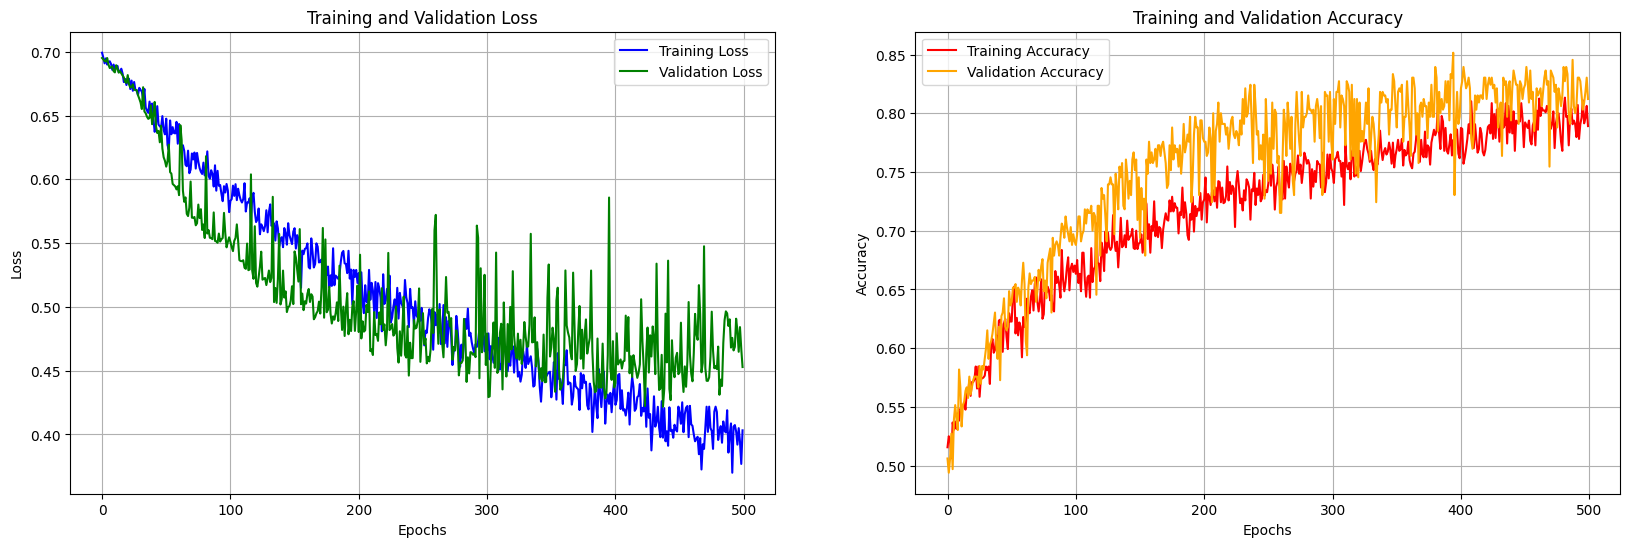

In [ ]:
epochs = np.arange(500)

# Figure Initialization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Loss Plot
ax1.plot(epochs, hist.history["loss"], color='blue', label='Training Loss')
ax1.plot(epochs, hist.history["val_loss"], color='green', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy Plot
ax2.plot(epochs, hist.history["accuracy"], color='red', label='Training Accuracy')
ax2.plot(epochs, hist.history["val_accuracy"], color='orange', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Display Plots
plt.show()



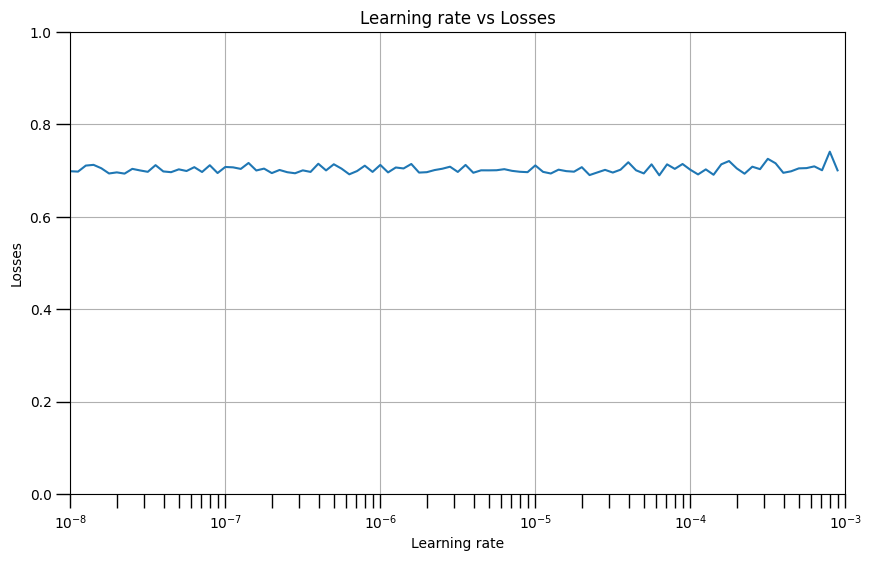

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 1])

plt.title('Learning rate vs Losses')
plt.xlabel('Learning rate')
plt.ylabel('Losses')
plt.show()

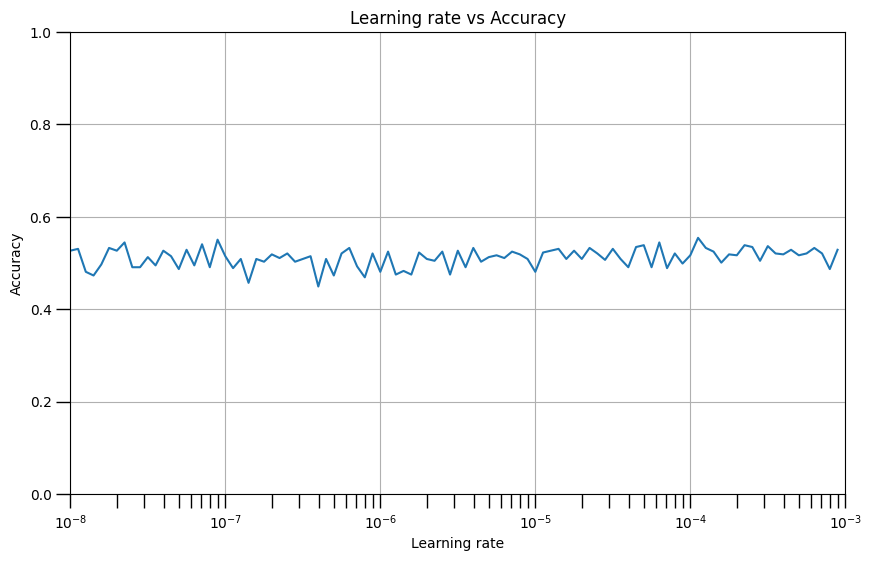

In [ ]:
# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["accuracy"])  # use 'val_accuracy' for validation accuracy
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 1])  # change the y-axis range to fit the accuracy (usually between 0 and 1)
plt.title('Learning rate vs Accuracy')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
# make predictions

# def image_loader(img_path):
#   raw_image = load_img(img_path, target_size=(100, 400), color_mode='rgb')
#   image = img_to_array(raw_image).astype('float32') / 255
#   return image

# test_gazing_dir = 'train/gazing'
# test_no_gazing_dir = 'train/no_gazing'

# test_gazing_images_list = [os.path.join(test_gazing_dir, fname) for fname in os.listdir(test_gazing_dir)]
# test_no_gazing_images_list = [os.path.join(test_no_gazing_dir, fname) for fname in os.listdir(test_no_gazing_dir)]

# for each in test_gazing_images_list:
#   image = image_loader(each)
#   image = np.expand_dims(image, axis=0)
#   result = vgg_model.predict(image)
#   print(f"Image: {each}, Prediction: {result[0][0]}")

# print("***************************************************")

# for each in test_no_gazing_images_list:
#   image = image_loader(each)
#   image = np.expand_dims(image, axis=0)
#   result = vgg_model.predict(image)
#   print(f"Image: {each}, Prediction: {result[0][0]}")


def predict(image_file, model):
  image = image_loader(image_file)
  image = np.expand_dims(image, axis=0)
  result = model.predict(image)
  if result[0][0] < 0.5:
    print("He/She is looking at you!")
  else:
    print("He/She is not having attention on you!")


def real_time_predict(image, model):
  image = np.expand_dims(image, axis=0)
  result = model.predict(image)
  return result[0][0] < 0.5

def image_loader(img_path):
    raw_image = load_img(img_path, color_mode='rgb')
    image = img_to_array(raw_image)
    return image.astype('uint8')



1/1 [==============================] - 0s 22ms/step
He/She is looking at you!


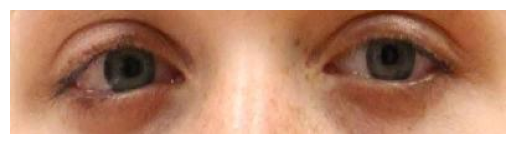

(100, 400, 3)


In [ ]:
sample_path = 'train/gazing/0035_2m_-15P_0V_5H.jpg'

predict(sample_path, vgg_model)
show_image(image_loader(sample_path))

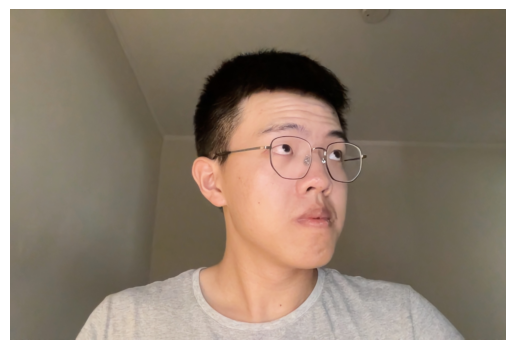

(1430, 2144, 3)


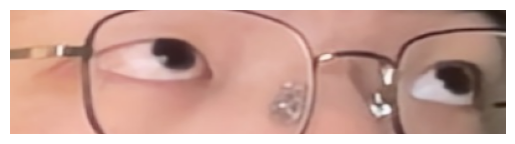

(100, 400, 3)
1/1 [==============================] - 0s 27ms/step


False

In [ ]:
sample_path = '/content/Photo on 7-24-23 at 1.28 AM #2.jpg'

image = image_loader(sample_path)
show_image(image)
cropped = get_cropped_image_eye(image, mp_face_mesh)
show_image(cropped)
real_time_predict(cropped, vgg_model)


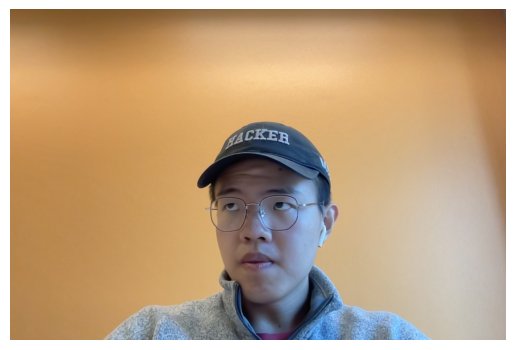

(1430, 2144, 3)


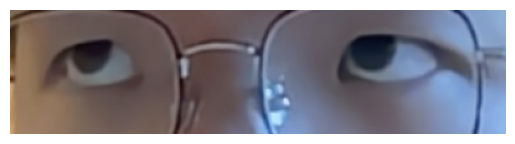

(100, 400, 3)
1/1 [==============================] - 0s 23ms/step


False

In [ ]:
sample_path = '/content/Photo on 7-31-23 at 5.07 PM.jpg'

image = image_loader(sample_path)
show_image(image)
cropped = get_cropped_image_eye(image, mp_face_mesh)
show_image(cropped)
real_time_predict(cropped, vgg_model)

#### 4. Inspect the performance and adjust hyperparameter

In [ ]:
def get_cropped_image_eye(image, mp_face_mesh):

    height, width, _ = image.shape

    face_mesh = mp_face_mesh.FaceMesh()
    results = face_mesh.process(image)

    if results.multi_face_landmarks:
      for face_landmarks in results.multi_face_landmarks:
        p1, p2 = face_landmarks.landmark[70], face_landmarks.landmark[340]
        x1 = int(p1.x * width)
        y1 = int(p1.y * height)
        x2 = int(p2.x * width)
        y2 = int(p2.y * height)
        top_left = (x1, y1)
        lower_right = (x2, y2)

      # crop the image
      cropped_image = tf.image.crop_to_bounding_box(image, y1, x1, y2-y1, x2-x1)

      # resize it to be (100, 400) for model training purpose
      cropped_image = tf.image.resize(cropped_image, (100,400)).numpy().astype('uint8')

      return cropped_image

def real_time_predict(image, model):
  image = np.expand_dims(image, axis=0)
  result = model.predict(image)
  return result[0][0] < 0.5

#### 5. Real Time Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
  success, image = cap.read()
  if not success:
    print('Ignoring empty camera frame.')
    continue

  height, width, _ = image.shape
  # Define the points for the rectangle - in this case, the entire frame
  pt1 = (0,0)
  pt2 = (width,height)

  image.flags.writeable = False
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  cropped_image = get_cropped_image_eye(image, mp_face_mesh)

  result = real_time_predict(cropped_image, vgg_model)

  image.flags.writeable = True
  image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)

  if result:
    image = cv2.rectangle(img, pt1, pt2, (0, 255, 0), 10)

  # Horizontally flip the image
  flipped_image = cv2.flip(image, 1)

  # Display the flipped image
  cv2.imshow('Image', flipped_image)

  if cv2.waitKey(5) & 0xFF == 27:
      break


In [ ]:
cap.release()
cv2.destroyAllWindows()